In [1]:
#Standard Imports
import numpy as np
import pandas as pd
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import sklearn.metrics as mtr
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import copy
from tensorflow.keras.metrics import Metric
import sklearn.ensemble as ens
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
import itertools

In [2]:
# load train data & shuffle
df_train = pd.read_csv('../data/training_set_(50_50).csv', index_col = 0).sample(frac=1)
x_train = df_train.drop(['ponzi'], axis=1)
y_train = df_train['ponzi']
# load test data & shuffle
df_test = pd.read_csv('../data/testing_set_(90_10).csv', index_col = 0).sample(frac=1)
x_test = df_test.drop(['ponzi'], axis=1)
y_test = df_test['ponzi']

print(x_train.shape, np.sum(y_train), x_test.shape, np.sum(y_test))

(41666, 27) 20833 (4999, 27) 499


In [3]:
#Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like
pt = PowerTransformer()
x_train_trans = pt.fit_transform(x_train)
x_test_trans = pt.transform(x_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


accuracy: 0.6133226645329066
specificity: 0.5802222222222222
precision non-fraud : 0.9834274952919021 precision fraud : 0.19411262798634812
recall non-fraud: 0.5802222222222222 recall fraud 0.9118236472945892
f2 non-fraud 0.6320503510045994 f2 fraud :  0.5241935483870968
f1: 0.32008441786844877
g mean:  0.7273653434884276
auc: 0.8498093965709197


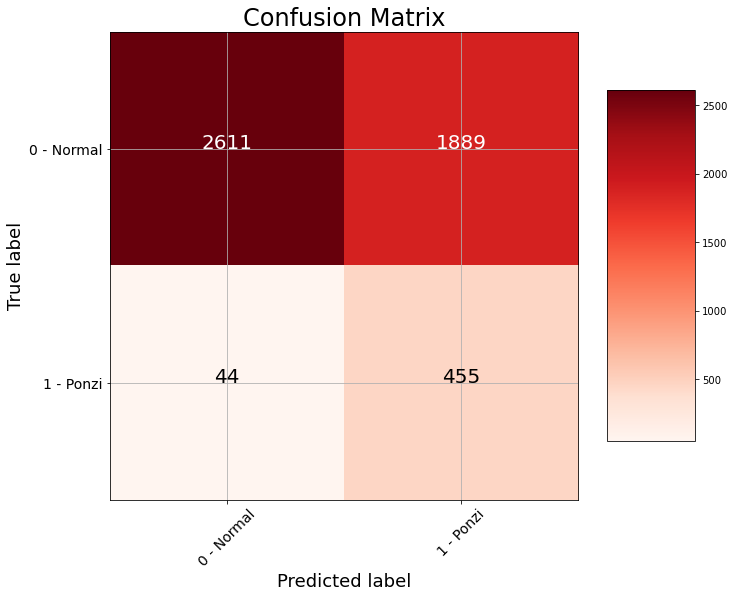

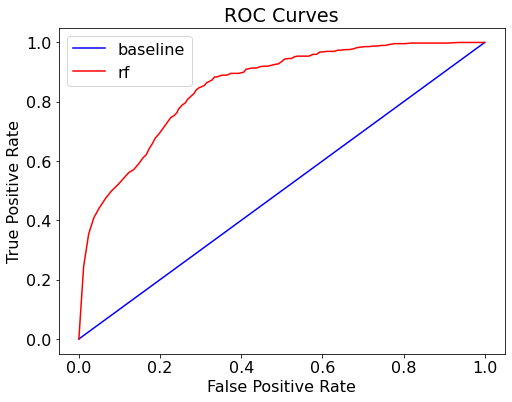

In [4]:
def plot_confusion_matrix(cm, classes, normalize = False):
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
    plt.title('Confusion Matrix', size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

    
def plot_roc_curve(y, prob):
    base_fpr, base_tpr, _ = mtr.roc_curve(y, [1 for _ in range(len(y))])
    model_fpr, model_tpr, _ = mtr.roc_curve(y, prob)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'rf')
    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

    
def train_test_measure(model, xtr, ytr, xte, yte):
    model.fit(xtr, ytr)
    y_test_pred = model.predict(xte)
    y_test_pred_proba = model.predict_proba(xte)[:,1]
    
    cm = mtr.confusion_matrix(yte, y_test_pred)
    plot_confusion_matrix(cm, ['0 - Normal', '1 - Ponzi'])

    specificity = cm[0][0] / (cm[0][0] + cm[0][1])
    recall = mtr.recall_score(yte,y_test_pred)
    results = (mtr.precision_recall_fscore_support(yte,y_test_pred,beta = 2))
    print('accuracy:', mtr.accuracy_score(yte,y_test_pred))
#    print('precision:', mtr.precision_score(yte,y_test_pred))
#    print('recall:', recall)
    print('specificity:', specificity)
    print('precision non-fraud :', results[0][0], 'precision fraud :', results[0][1])
    print('recall non-fraud:', results[1][0], "recall fraud", results[1][1])
    print('f2 non-fraud', results[2][0], "f2 fraud : ", results[2][1] )
    print('f1:',  mtr.f1_score(yte,y_test_pred))
    print('g mean: ', (recall*specificity)**0.5)
    print('auc:', mtr.roc_auc_score(yte, y_test_pred_proba))
    plot_roc_curve(yte, y_test_pred_proba)
    
    
#result without parameter tuning as a baseline
rf = ens.RandomForestClassifier(random_state=100, n_jobs=-1)
train_test_measure(rf, x_train_trans, y_train, x_test_trans, y_test)

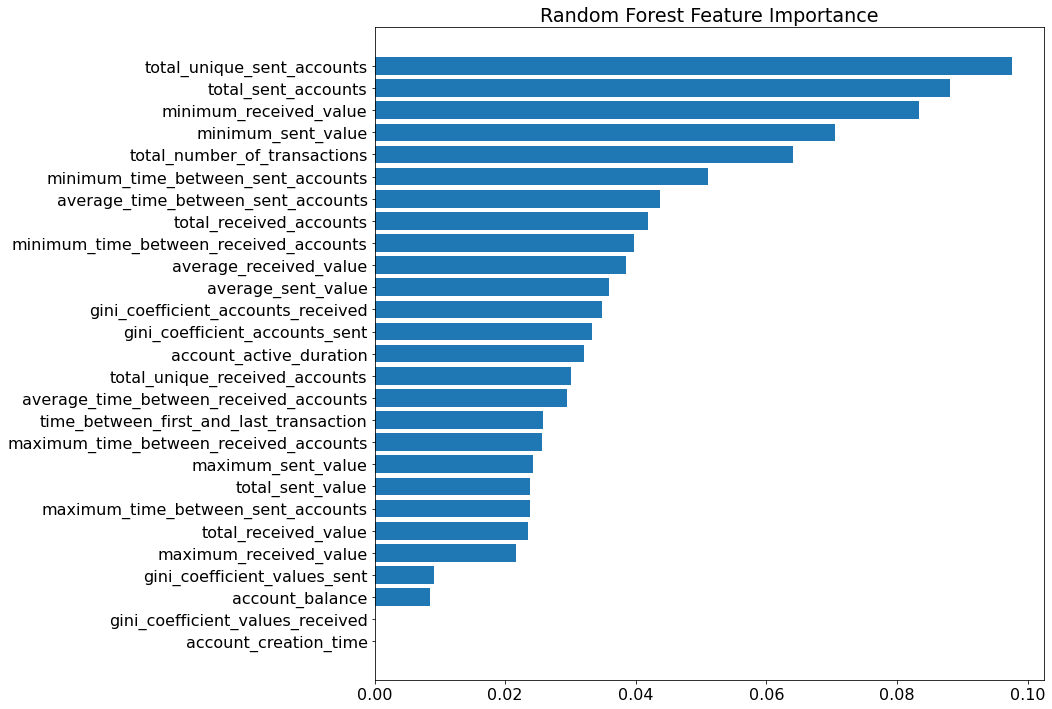

In [5]:
def feature_importance(ds, rf):
    feature_importances = list(zip(ds.columns.values, rf.feature_importances_))
    feature_importances_sorted = sorted(feature_importances, key = lambda x: x[1])

    y_ticks = [i[0] for i in feature_importances_sorted] 
    x_axis = [i[1] for i in feature_importances_sorted]
    plt.figure(figsize = (12, 12))
    plt.barh(y_ticks, x_axis)
    plt.title('Random Forest Feature Importance')
    plt.show()
        
feature_importance(x_train, rf)

In [9]:
def cv(model, params, X, y, scoring ):
  gs = GridSearchCV(model, params, scoring=scoring ,n_jobs=-1)
  gs.fit(X, y)
  result = gs.best_params_
  result['best_score'] = gs.best_score_
  result['best_estimator'] = gs.best_estimator_
  return result 

#cv params
fbeta_scorer = mtr.make_scorer(mtr.fbeta_score, beta=2)
params = {'criterion': ['gini', 'entropy'], 'n_estimators': [500, 800, 1000], 'max_depth': [None, 50, 100], 'max_features': [None,'auto', 'log2']}


In [72]:
cv_result = cv(ens.RandomForestClassifier(random_state=100, n_jobs=-1), params, x_train_trans, y_train, fbeta_scorer)
print('fbeta 2:', cv_result)

fbeta 2: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 1000, 'best_score': 0.9120535951762883, 'best_estimator': RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=100)}


accuracy: 0.6149229845969194
specificity: 0.5817777777777777
precision non-fraud : 0.9838406614054866 precision fraud : 0.19503849443969204
recall non-fraud: 0.5817777777777777 recall fraud 0.9138276553106213
f2 non-fraud 0.6335608150621944 f2 fraud :  0.5260729118597139
f1: 0.32146633768064853
g mean:  0.7291396454579124
auc: 0.8535626809173903


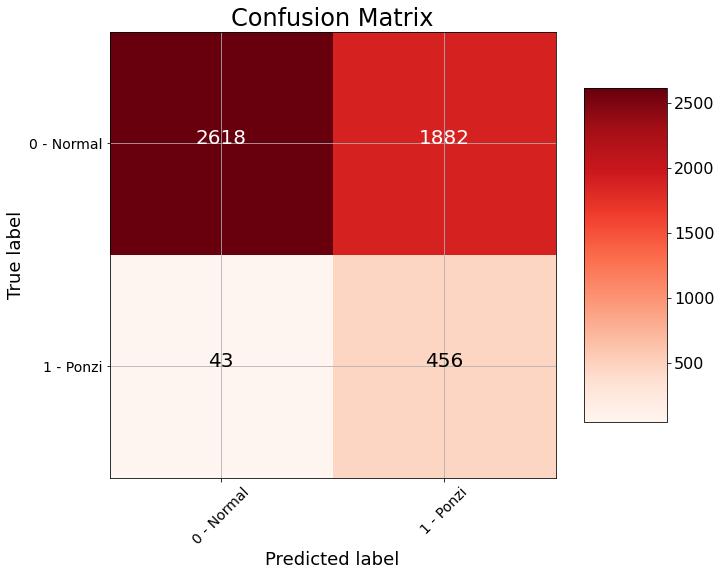

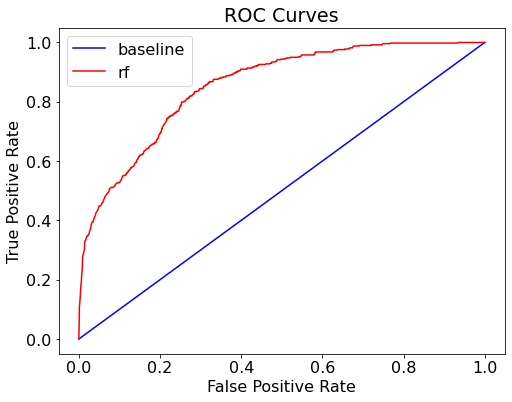

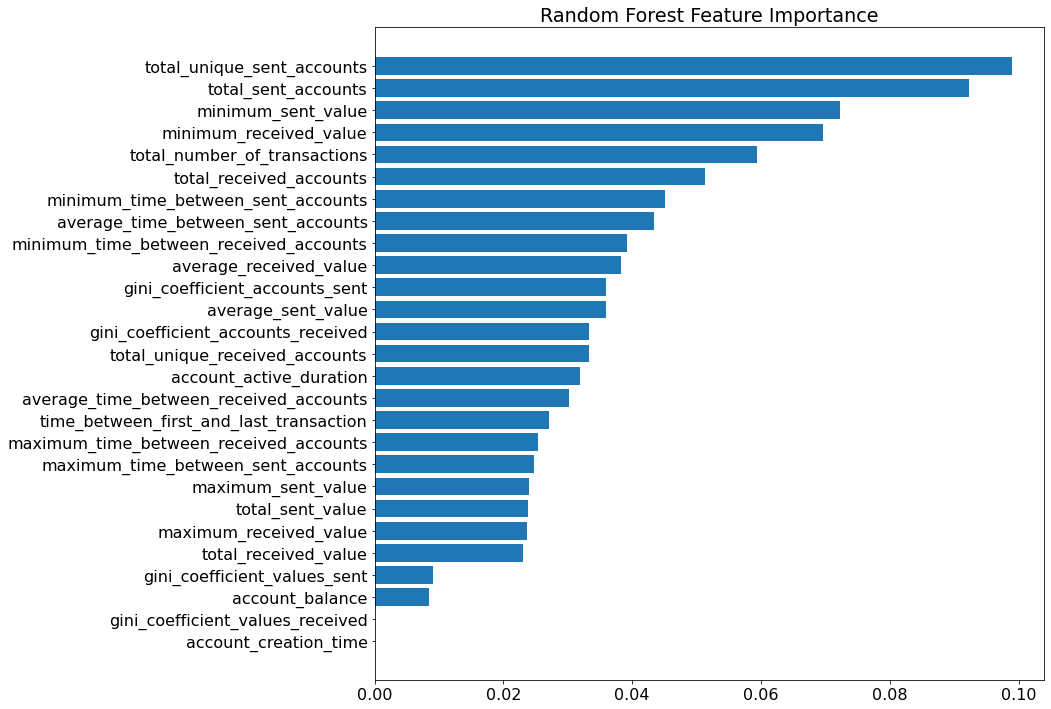

In [9]:
# based on the cv best result parameters above
rf = ens.RandomForestClassifier(criterion = 'gini', max_depth = None, max_features = 'auto', n_estimators = 1000, random_state=100, n_jobs=-1)
train_test_measure(rf, x_train_trans, y_train, x_test_trans, y_test)
feature_importance(x_train, rf)

In [10]:
# try PCA
pca_components = [0.99, 25, 23, 20]
cv_pca_results = {}
for n in pca_components:
    pca = PCA(n_components=n, random_state=100)
    x_pca_train = pca.fit_transform(x_train_trans)
#    x_pca_test = pca.transform(x_test_trans)
    cv_result = cv(ens.RandomForestClassifier(random_state=100, n_jobs=-1), params, x_pca_train, y_train, fbeta_scorer)
    cv_result['pca'] = pca
    cv_pca_results[str(n)] = cv_result
    
print(cv_pca_results)

{'0.99': {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 800, 'best_score': 0.8926639733910575, 'best_estimator': RandomForestClassifier(n_estimators=800, n_jobs=-1, random_state=100), 'pca': PCA(n_components=0.99, random_state=100)}, '25': {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 1000, 'best_score': 0.8930021223149943, 'best_estimator': RandomForestClassifier(criterion='entropy', n_estimators=1000, n_jobs=-1,
                       random_state=100), 'pca': PCA(n_components=25, random_state=100)}, '23': {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 800, 'best_score': 0.8928502087265897, 'best_estimator': RandomForestClassifier(criterion='entropy', n_estimators=800, n_jobs=-1,
                       random_state=100), 'pca': PCA(n_components=23, random_state=100)}, '20': {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 500, 'best_score': 0

accuracy: 0.6563312662532507
specificity: 0.6282222222222222
precision non-fraud : 0.9843314763231198 precision fraud : 0.21344616831217678
recall non-fraud: 0.6282222222222222 recall fraud 0.9098196392785571
f2 non-fraud 0.677223073974703 f2 fraud :  0.5505699733203978
f1: 0.3457730388423458
g mean:  0.7560217692692426
auc: 0.8966009797372523


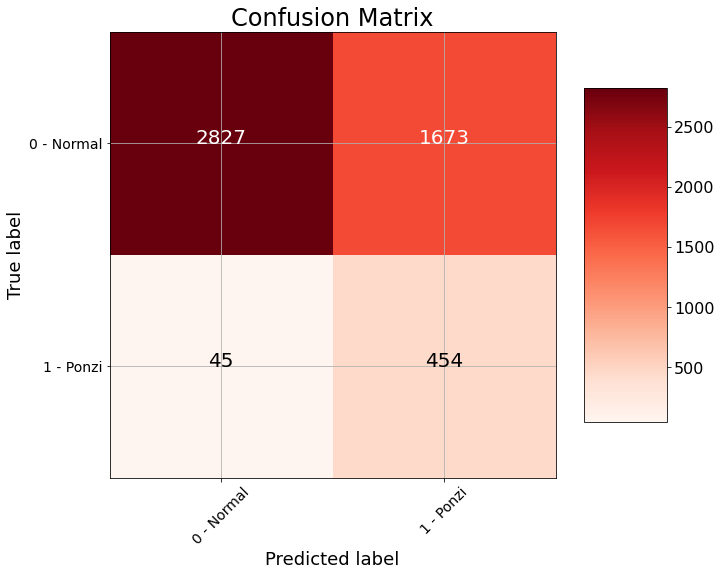

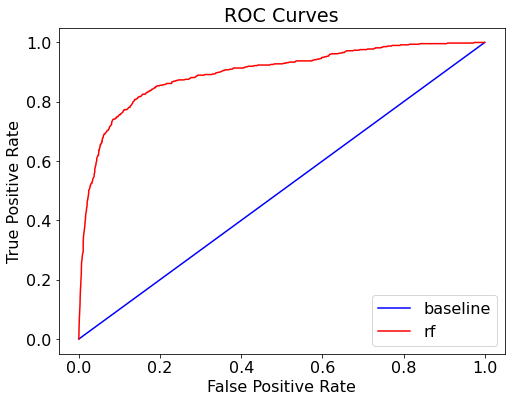

In [7]:
#best_pca = cv_pca_results['20']['pca']
#best_estimator = cv_pca_results['20']['best_estimator']
best_pca = PCA(n_components=20, random_state=100)
x_pca_train = best_pca.fit_transform(x_train_trans)
x_pca_test = best_pca.transform(x_test_trans)
best_estimator = ens.RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=100, n_jobs=-1)
train_test_measure(best_estimator, x_pca_train, y_train, x_pca_test, y_test)